# Transfer Learning - Fashion MNIST

Transfer Learning allows us to learn faster from a pre-trained model (on a similiar problem) by getting the feature transformation part

In [3]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline
import vis

### Get Data 

In [2]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
labels = vis.fashion_mnist_label()

**Step 1: Prepare the images and labels**

In [6]:
# Reshape data for convlution netowkr
x_train_conv = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_conv = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Convert from 'uint8' to 'float32' and normalise the data to (0,1) 
x_train_conv =  x_train_conv.astype("float32") / 255
x_test_conv = x_test_conv.astype("float32") / 255

# convert class vectors to binary class matrices
y_train_class = keras.utils.to_categorical(y_train, 10)
y_test_class = keras.utils.to_categorical(y_test, 10)

Resize the image for the transfer learning model

Lets resize the image from (28,28,1) to (48,48,3)

In [7]:
from skimage.transform import resize

In [8]:
def resize_image(image):
    return resize(image, (96,96,3), mode="symmetric")

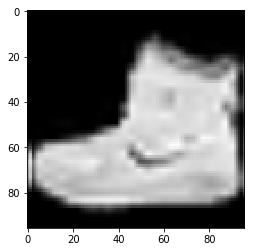

In [14]:
plt.imshow(resize_image(x_train_conv[0]));

Lets resize the 10000 images in train and test data

In [16]:
%timeit
x_train_conv_resize = np.array([resize_image(x_train_conv[x]) for x in range(x_train_conv[:10000].shape[0])])
x_train_conv_resize.shape

(10000, 96, 96, 3)

In [17]:
%timeit
x_test_conv_resize = np.array([resize_image(x_test_conv[x]) for x in range(x_test_conv.shape[0])])
x_test_conv_resize.shape

(10000, 96, 96, 3)

**Step 2: Load a pre-trained model for the feature transfomation and add classifier model **

Let us load the VGG model without the classifier layer and **do not** train the weights

In [18]:
from keras.applications.vgg16 import VGG16

In [19]:
conv_base = VGG16(include_top=False, weights='imagenet', 
                        input_tensor=None, input_shape=(96,96,3), pooling="avg")

In [20]:
conv_base.trainable = False

In [21]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

Lets build a Dense Layer Classifier after that to classify the fashion mnist data

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [27]:
model_transfer = Sequential()
model_transfer.add(conv_base)
model_transfer.add(Dense(128, activation='relu'))
model_transfer.add(Dropout(0.25))
model_transfer.add(Dense(64, activation='relu'))
model_transfer.add(Dense(10, activation='softmax'))

In [28]:
model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 14,789,258
Trainable params: 74,570
Non-trainable params: 14,714,688
_________________________________________________________________


**Step 3: Compile and fit the model**

In [29]:
model_transfer.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [30]:
%time
history_transfer = model_transfer.fit(x_train_conv_resize, y_train_class[:10000], 
                                      batch_size=128, epochs=5, verbose=1, validation_split = 0.2)

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 33.1 µs
Train on 8000 samples, validate on 2000 samples
Epoch 1/5
 896/8000 [==>...........................] - ETA: 1:15:00 - loss: 2.3184 - acc: 0.1172

KeyboardInterrupt: 

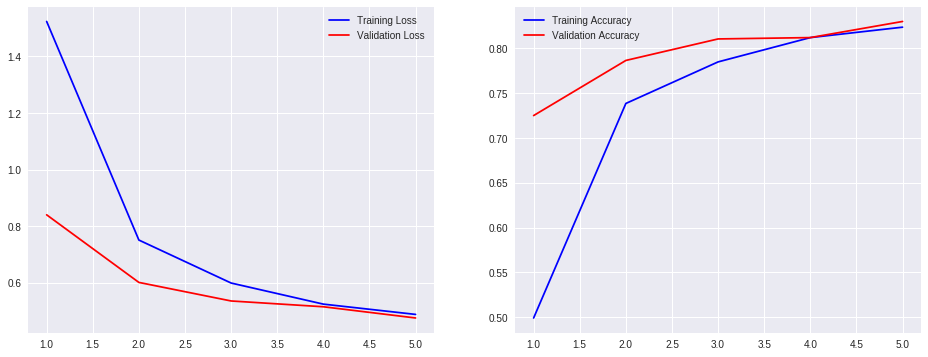

In [35]:
plot_metrics(history_transfer)

In [40]:
score = model_transfer.evaluate(x_test_conv_resize, y_test_class, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 24s 2ms/step
Test loss: 0.4677408727169037
Test accuracy: 0.8301
